In [0]:
!pip install torch
!pip install torchvision

In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import Image
from IPython.display import display 
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torchsummary
import numpy as np
from collections import namedtuple

import copy
import time
import glob
import re
import cv2

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2019-03-30 06:50:40--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.98.147
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.98.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip.2’

val2017.zip.2       100%[===================>] 777.80M  37.0MB/s    in 22s     

2019-03-30 06:51:01 (36.1 MB/s) - ‘val2017.zip.2’ saved [815585330/815585330]



Download COCO Dataset - http://images.cocodataset.org/zips/val2017.zip

some differences:

Original paper: COCO 2014 train --> 80000 images & 13GB

My implementation: COCO 2017 val --> 5000 images / 1GB --> x16 epochs

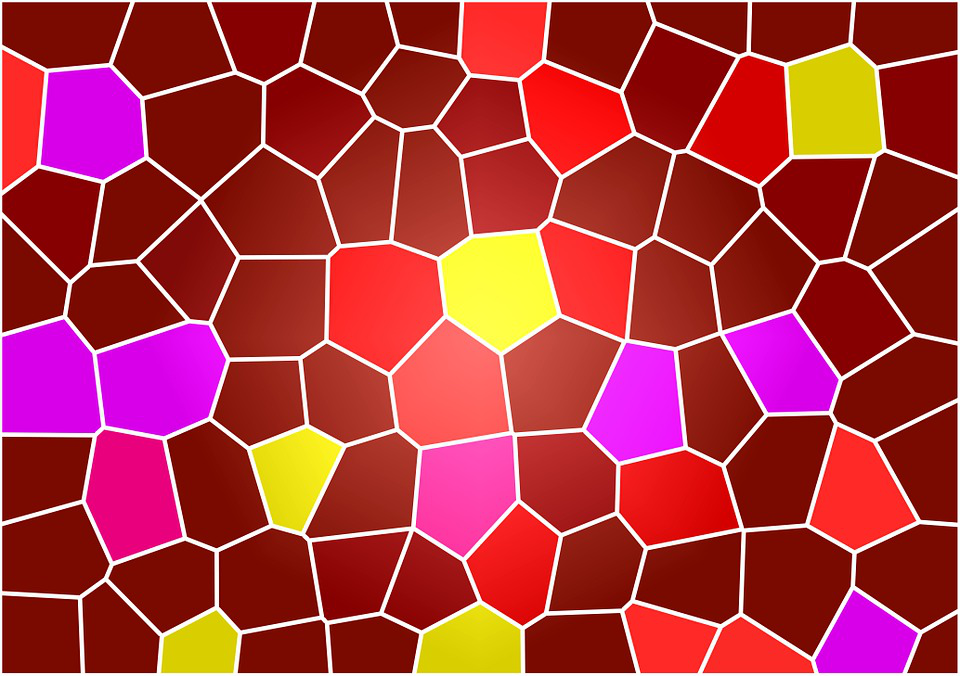

In [0]:
style_image_location = "/content/mosaic_5.jpg" #FIXME
style_image_sample = Image.open(style_image_location, 'r')
display(style_image_sample)

In [0]:
batch_size = 8
random_seed = 10
num_epochs = 64 
initial_lr = 1e-3
checkpoint_dir = "/content/data/" #FIXME

content_weight = 1e5
style_weight = 1e10
log_interval = 50
checkpoint_interval = 500

#running_option = "test" #FIXME 
#running_option = "test_video" #FIXME
running_option = "training" #FIXME

In [0]:
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [0]:
class ResidualBlock(nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out

In [0]:
class UpsampleConvLayer(nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [0]:
class TransformerNet(nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.encoder = nn.Sequential()
        
        self.encoder.add_module('conv1', ConvLayer(3, 32, kernel_size=9, stride=1))
        self.encoder.add_module('in1', nn.InstanceNorm2d(32, affine=True))
        self.encoder.add_module('relu1', nn.ReLU())
        
        self.encoder.add_module('conv2', ConvLayer(32, 64, kernel_size=3, stride=2))
        self.encoder.add_module('in2', nn.InstanceNorm2d(64, affine=True))
        self.encoder.add_module('relu2', nn.ReLU())
        
        self.encoder.add_module('conv3', ConvLayer(64, 128, kernel_size=3, stride=2))
        self.encoder.add_module('in3', nn.InstanceNorm2d(128, affine=True))
        self.encoder.add_module('relu3', nn.ReLU())

        # Residual layers
        self.residual = nn.Sequential()
        
        for i in range(5):
          self.residual.add_module('resblock_%d' %(i+1), ResidualBlock(128))
        
        # Upsampling Layers
        self.decoder = nn.Sequential()
        self.decoder.add_module('deconv1', UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2))
        self.decoder.add_module('in4', nn.InstanceNorm2d(64, affine=True))
        self.encoder.add_module('relu4', nn.ReLU())

        self.decoder.add_module('deconv2', UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2))
        self.decoder.add_module('in5', nn.InstanceNorm2d(32, affine=True))
        self.encoder.add_module('relu5', nn.ReLU())

        self.decoder.add_module('deconv3', ConvLayer(32, 3, kernel_size=9, stride=1))


    def forward(self, x):
        encoder_output = self.encoder(x)
        residual_output = self.residual(encoder_output)
        decoder_output = self.decoder(residual_output)
        
        return decoder_output

(720, 1280, 3)


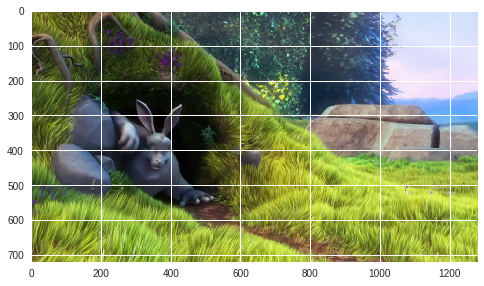

In [0]:
# Video Capture Sanity Check
cap = cv2.VideoCapture("/content/SampleVideo_1280x720_30mb.mp4")

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = frame[:,:,::-1]
    
    print(frame.shape)
    
    plt.imshow(frame)
    
    break
cap.release()
cv2.destroyAllWindows()

In [0]:
""" Util Functions """
def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img
    

def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    display(img)
    img.save(filename)

def post_process_image(data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    #img = Image.fromarray(img)
    
    return img
    

def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std

In [0]:
!mkdir data

In [0]:
!unzip val2017.zip -d '/content/data'

Archive:  val2017.zip
   creating: /content/data/val2017/
 extracting: /content/data/val2017/000000212226.jpg  
 extracting: /content/data/val2017/000000231527.jpg  
 extracting: /content/data/val2017/000000578922.jpg  
 extracting: /content/data/val2017/000000062808.jpg  
 extracting: /content/data/val2017/000000119038.jpg  
 extracting: /content/data/val2017/000000114871.jpg  
 extracting: /content/data/val2017/000000463918.jpg  
 extracting: /content/data/val2017/000000365745.jpg  
 extracting: /content/data/val2017/000000320425.jpg  
 extracting: /content/data/val2017/000000481404.jpg  
 extracting: /content/data/val2017/000000314294.jpg  
 extracting: /content/data/val2017/000000335328.jpg  
 extracting: /content/data/val2017/000000513688.jpg  
 extracting: /content/data/val2017/000000158548.jpg  
 extracting: /content/data/val2017/000000132116.jpg  
 extracting: /content/data/val2017/000000415238.jpg  
 extracting: /content/data/val2017/000000321333.jpg  
 extracting: /content/da

In [0]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
])

print(glob.glob("/content/data/val2017/*"))

train_dataset = datasets.ImageFolder("/content/data/", transform) #FIXME
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

['/content/data/val2017/000000320632.jpg', '/content/data/val2017/000000446206.jpg', '/content/data/val2017/000000226111.jpg', '/content/data/val2017/000000368982.jpg', '/content/data/val2017/000000341196.jpg', '/content/data/val2017/000000085772.jpg', '/content/data/val2017/000000338718.jpg', '/content/data/val2017/000000099114.jpg', '/content/data/val2017/000000551215.jpg', '/content/data/val2017/000000344909.jpg', '/content/data/val2017/000000127263.jpg', '/content/data/val2017/000000544565.jpg', '/content/data/val2017/000000109313.jpg', '/content/data/val2017/000000319696.jpg', '/content/data/val2017/000000128699.jpg', '/content/data/val2017/000000051938.jpg', '/content/data/val2017/000000450202.jpg', '/content/data/val2017/000000568710.jpg', '/content/data/val2017/000000125245.jpg', '/content/data/val2017/000000029675.jpg', '/content/data/val2017/000000147415.jpg', '/content/data/val2017/000000088432.jpg', '/content/data/val2017/000000112798.jpg', '/content/data/val2017/0000002450

In [0]:
transformer = TransformerNet()
vgg = VGG16(requires_grad=False).to(device)
transformer.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:07, 74281268.01it/s]


TransformerNet(
  (encoder): Sequential(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
      (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
    )
    (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (relu1): ReLU()
    (conv2): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    )
    (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (relu2): ReLU()
    (conv3): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    )
    (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (relu3): ReLU()
    (relu4): ReLU()
    (relu5): ReLU()
  )
  (residual): Sequential(
    (resblock_1): ResidualBlock(
      (conv1): ConvLayer(
        (reflection_pad): Reflecti

In [0]:
optimizer = torch.optim.Adam(transformer.parameters(), initial_lr)
mse_loss = nn.MSELoss()

style = load_image(filename=style_image_location, size=None, scale=None)
style = style_transform(style)
style = style.repeat(batch_size, 1, 1, 1).to(device)

features_style = vgg(normalize_batch(style))
gram_style = [gram_matrix(y) for y in features_style]

In [0]:
transfer_learning = True # inference or training first --> False / Transfer learning --> True
ckpt_model_path = "/content/ckpt_epoch_63_batch_id_500.pth" #FIXME

if transfer_learning:
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  transformer.load_state_dict(checkpoint['model_state_dict'])
  transformer.to(device)
  transformer.cuda()

In [0]:
if running_option == "training":
  if transfer_learning:
      transfer_learning_epoch = checkpoint['epoch'] 
  else:
      transfer_learning_epoch = 0

  for epoch in range(transfer_learning_epoch, num_epochs):
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0

        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x)

            y = normalize_batch(y)
            x = normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
            style_loss *= style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), epoch + 1, count, len(train_dataset),
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

            if checkpoint_dir is not None and (batch_id + 1) % checkpoint_interval == 0:
                transformer.eval().cpu()
                ckpt_model_filename = "ckpt_epoch_" + str(epoch) + "_batch_id_" + str(batch_id + 1) + ".pth"
                print(str(epoch), "th checkpoint is saved!")
                ckpt_model_path = os.path.join(checkpoint_dir, ckpt_model_filename)
                torch.save({
                'epoch': epoch,
                'model_state_dict': transformer.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': total_loss
                }, ckpt_model_path)

                transformer.to(device).train()  

Sat Mar 30 11:06:55 2019	Epoch 64:	[400/5000]	content: 551693.172813	style: 22306145.100000	total: 22857838.272813
Sat Mar 30 11:08:25 2019	Epoch 64:	[800/5000]	content: 597677.083281	style: 14667477.425000	total: 15265154.508281
Sat Mar 30 11:09:54 2019	Epoch 64:	[1200/5000]	content: 635125.538854	style: 11499198.276667	total: 12134323.815521
Sat Mar 30 11:11:24 2019	Epoch 64:	[1600/5000]	content: 673867.438828	style: 9643236.650000	total: 10317104.088828
Sat Mar 30 11:12:54 2019	Epoch 64:	[2000/5000]	content: 713264.774313	style: 8367853.290000	total: 9081118.064313
Sat Mar 30 11:14:24 2019	Epoch 64:	[2400/5000]	content: 756716.763594	style: 7407983.470000	total: 8164700.233594
Sat Mar 30 11:15:54 2019	Epoch 64:	[2800/5000]	content: 798932.762545	style: 6663328.781429	total: 7462261.543973
Sat Mar 30 11:17:23 2019	Epoch 64:	[3200/5000]	content: 834713.913789	style: 6070732.031875	total: 6905445.945664
Sat Mar 30 11:18:53 2019	Epoch 64:	[3600/5000]	content: 866225.717535	style: 558724

In [0]:
!wget https://assets.simpleviewcms.com/simpleview/image/upload/c_fill,h_406,q_65,w_587/v1/clients/norway/Helgeland-hiking-Rodoy-Norway-2-1_c3ea0777-bf05-4677-98ca-a6028c3d0564.jpg

--2019-03-30 10:36:28--  https://assets.simpleviewcms.com/simpleview/image/upload/c_fill,h_406,q_65,w_587/v1/clients/norway/Helgeland-hiking-Rodoy-Norway-2-1_c3ea0777-bf05-4677-98ca-a6028c3d0564.jpg
Resolving assets.simpleviewcms.com (assets.simpleviewcms.com)... 104.20.193.66, 104.20.192.66, 2606:4700:10::6814:c142, ...
Connecting to assets.simpleviewcms.com (assets.simpleviewcms.com)|104.20.193.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45881 (45K) [image/jpeg]
Saving to: ‘Helgeland-hiking-Rodoy-Norway-2-1_c3ea0777-bf05-4677-98ca-a6028c3d0564.jpg’

Helgeland-hiking-Ro 100%[===================>]  44.81K  --.-KB/s    in 0.005s  

2019-03-30 10:36:28 (8.99 MB/s) - ‘Helgeland-hiking-Rodoy-Norway-2-1_c3ea0777-bf05-4677-98ca-a6028c3d0564.jpg’ saved [45881/45881]



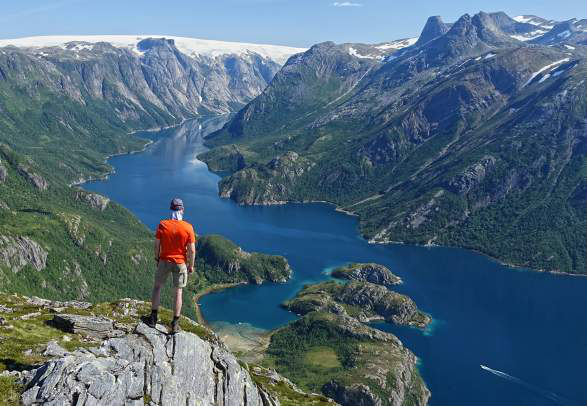

In [0]:
content_image_sample = Image.open('/content/Helgeland-hiking-Rodoy-Norway-2-1_c3ea0777-bf05-4677-98ca-a6028c3d0564.jpg', 'r')
display(content_image_sample)

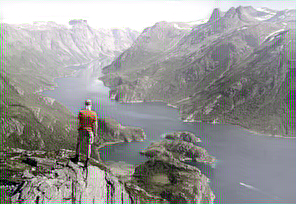

In [0]:
running_option = "test"
if running_option == "test":
    content_image = load_image("/content/Helgeland-hiking-Rodoy-Norway-2-1_c3ea0777-bf05-4677-98ca-a6028c3d0564.jpg", scale=2) #FIXME
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    with torch.no_grad():
        style_model = TransformerNet()
        
        ckpt_model_path = "/content/ckpt_epoch_63_batch_id_500.pth" #FIXME
        checkpoint = torch.load(ckpt_model_path, map_location=device)
        
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(checkpoint.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del checkpoint[k]
        
        style_model.load_state_dict(checkpoint['model_state_dict'])
        style_model.to(device)
        
        output = style_model(content_image).cpu()
        
    save_image("/content/result.png", output[0]) #FIXME

In [0]:
if running_option == "test_video":
    
    with torch.no_grad():
        style_model = TransformerNet()

        ckpt_model_path = "/content/ckpt_epoch_63_batch_id_500.pth"
        checkpoint = torch.load(ckpt_model_path, map_location=device)

        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(checkpoint.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del checkpoint[k]

        style_model.load_state_dict(checkpoint['model_state_dict'])
        style_model.to(device)

        cap = cv2.VideoCapture("/content/SampleVideo_1280x720_30mb.mp4") #FIXME

        frame_cnt = 0
        
        fourcc = cv2.VideoWriter_fourcc(*'XVID') 
        out = cv2.VideoWriter('/content/video_result.avi', fourcc, 60.0, (1920,1080)) #FIXME

        
        while(cap.isOpened()):
            ret, frame = cap.read()
            
            try:
              frame = frame[:,:,::-1] - np.zeros_like(frame)
            except:
              break
              
            print(frame_cnt, "th frame is loaded!")

            content_image = frame
            content_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.mul(255))
            ])
            content_image = content_transform(content_image)
            content_image = content_image.unsqueeze(0).to(device)

            output = style_model(content_image).cpu()
            #save_image("/content/gdrive/My Drive/Colab_Notebooks/data/vikendi_video_result/" + str(frame_cnt) +".png", output[0]) #FIXME
            out.write(post_process_image(output[0]))
            frame_cnt += 1
            

        cap.release()
        out.release()
        cv2.destroyAllWindows()
  


0 th frame is loaded!
1 th frame is loaded!
2 th frame is loaded!
3 th frame is loaded!
4 th frame is loaded!
5 th frame is loaded!
6 th frame is loaded!
7 th frame is loaded!
8 th frame is loaded!
9 th frame is loaded!
10 th frame is loaded!
11 th frame is loaded!
12 th frame is loaded!
13 th frame is loaded!
14 th frame is loaded!
15 th frame is loaded!
16 th frame is loaded!
17 th frame is loaded!
18 th frame is loaded!
19 th frame is loaded!
20 th frame is loaded!
21 th frame is loaded!
22 th frame is loaded!
23 th frame is loaded!
24 th frame is loaded!
25 th frame is loaded!
26 th frame is loaded!
27 th frame is loaded!
28 th frame is loaded!
29 th frame is loaded!
30 th frame is loaded!
31 th frame is loaded!
32 th frame is loaded!
33 th frame is loaded!
34 th frame is loaded!
35 th frame is loaded!
36 th frame is loaded!
37 th frame is loaded!
38 th frame is loaded!
39 th frame is loaded!
40 th frame is loaded!
41 th frame is loaded!
42 th frame is loaded!
43 th frame is loaded